In [25]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input"))
import tensorflow as tf
from keras import regularizers

['autism-image-data']


In [26]:
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D,Lambda,GlobalAveragePooling2D
import numpy as np
from keras.applications import VGG19,VGG16,MobileNetV2
from keras.models import Model
from keras import optimizers , layers, applications
from keras.layers import Reshape


In [27]:
filenames = os.listdir("../input/autism-image-data/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

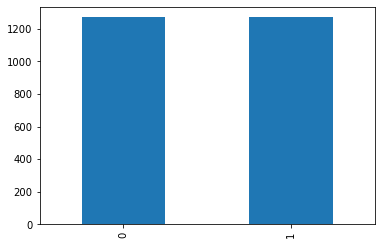

In [28]:
train_df['category'].value_counts().plot.bar()

In [29]:
test_filenames = os.listdir("../input/autism-image-data/AutismDataset/test")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [30]:
test_df.head()



,filename,category
0,Non_Autistic.609.jpg,0
1,Autistic.1124.jpg,1
2,Non_Autistic.979.jpg,0
3,Autistic.886.jpg,1
4,Non_Autistic.469.jpg,0


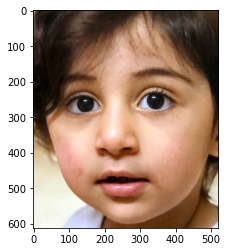

In [31]:
sample = random.choice(filenames)
image = load_img("../input/autism-image-data/AutismDataset/train/"+sample)
plt.imshow(image)

In [32]:

# image_size = 224
# input_shape = (image_size, image_size, 3)
# num_classes = 2  # Assuming binary classification

# # Hyperparameters
# epochs = 30
# batch_size = 64

# def local_response_normalization(x, depth_radius=2, alpha=1e-4, beta=0.75, bias=2.0):
#       return tf.nn.local_response_normalization(x, depth_radius=depth_radius, alpha=alpha, beta=beta, bias=bias)

# # pre_trained_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")
# pre_trained_model = VGG19(input_shape=input_shape, include_top=False, weights="imagenet")
    
# last_layer = pre_trained_model.get_layer('out_relu')
# last_output = last_layer.output

# x = Lambda(lambda j: local_response_normalization(j))(last_output)
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(num_classes, activation='softmax')(x)

# model = Model(pre_trained_model.input, x)

# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
#               metrics=['accuracy'])

# model.summary()

In [33]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Define the input shape
image_size = 224
input_shape = (image_size, image_size, 3)

# Load the pre-trained VGG19 model
pre_trained_model = VGG19(input_shape=input_shape, include_top=False, weights="imagenet")
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

# Apply local response normalization
x = Lambda(lambda j: local_response_normalization(j))(last_output)

# Global max pooling
x = GlobalMaxPooling2D()(x)

# Add a dense layer with reduced units and increased L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)

# Dropout layer
x = Dropout(0.5)(x)

# Output layer
x = Dense(2, activation='softmax')(x)

# Create the model
model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [34]:
# Prepare Test and Train Data
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]


In [35]:
# Training Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/autism-image-data/AutismDataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2286 validated image filenames belonging to 2 classes.


In [36]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/autism-image-data/AutismDataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 254 validated image filenames belonging to 2 classes.


In [37]:
#Fit Model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/10
35/35 [==============================] - 32s 911ms/step - loss: 4.7984 - accuracy: 0.5513 - val_loss: 4.6527 - val_accuracy: 0.6510
Epoch 2/10
35/35 [==============================] - 31s 900ms/step - loss: 4.5755 - accuracy: 0.6683 - val_loss: 4.4432 - val_accuracy: 0.7552
Epoch 3/10
35/35 [==============================] - 32s 901ms/step - loss: 4.4285 - accuracy: 0.6985 - val_loss: 4.3259 - val_accuracy: 0.7344
Epoch 4/10
35/35 [==============================] - 32s 908ms/step - loss: 4.2767 - accuracy: 0.7322 - val_loss: 4.1674 - val_accuracy: 0.7708
Epoch 5/10
35/35 [==============================] - 33s 937ms/step - loss: 4.1478 - accuracy: 0.7516 - val_loss: 4.0733 - val_accuracy: 0.7812
Epoch 6/10
35/35 [==============================] - 33s 938ms/step - loss: 4.0366 - accuracy: 0.7669 - val_loss: 3.9549 - val_accuracy: 0.7917
Epoch 7/10
35/35 [==============================] - 32s 917ms/step - loss: 3.9208 - accuracy: 0.7732 - val_loss: 3.8036 - val_accuracy: 0.8177

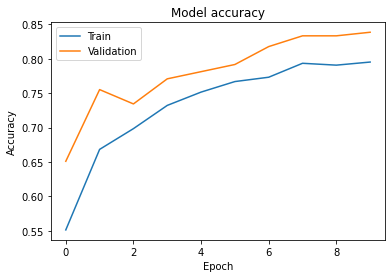

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [39]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.812500  ;  loss = 3.526686 


In [45]:
import io
import ipywidgets as widgets
from PIL import Image
import tensorflow as tf

# Load your model
# model = tf.keras.applications.MobileNetV2(weights='imagenet')

# Define a function to preprocess the image
def preprocess_image(image_data):
    img = Image.open(io.BytesIO(image_data))
    img = img.resize((224, 224))  # Resize the image to the required input size
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Create a file upload widget
upload_widget = widgets.FileUpload()

# Display the file upload widget
display(upload_widget)

def on_upload_change(change):
    # Get the uploaded image
    uploaded_image = upload_widget.value[next(iter(upload_widget.value))]
    image_data = uploaded_image['content']
    
    # Preprocess the image
    processed_image = preprocess_image(image_data)
    
    # Make a prediction
    prediction = model.predict(processed_image.reshape(1, 224, 224, 3))
    print('Prediction:', tf.keras.applications.mobilenet_v2.decode_predictions(prediction, top=1)[0])
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is AUTISTIC")
    else:
        print(fn + " is NOT AUTISTIC")
# Register the callback function to run when a file is uploaded
upload_widget.observe(on_upload_change, names='_counter')


FileUpload(value={}, description='Upload')

In [40]:
model.save('vgg19.h5')